In [1]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import argparse
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
%matplotlib inline
import random
import os

In [ ]:
# !unrar x "/content/drive/MyDrive/MajorP/PNEUMONIA.rar" "/content/drive/MyDrive/MajorP/datax/sharp/"


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/drive/MyDrive/MajorP/PNEUMONIA.rar

Creating    /content/drive/MyDrive/MajorP/datax/sharp/PNEUMONIA       OK
Extracting  /content/drive/MyDrive/MajorP/datax/sharp/PNEUMONIA/person1000_bacteria_2931.jpeg       0%  OK 
Extracting  /content/drive/MyDrive/MajorP/datax/sharp/PNEUMONIA/person1000_virus_1681.jpeg       0%  OK 
Extracting  /content/drive/MyDrive/MajorP/datax/sharp/PNEUMONIA/person1001_bacteria_2932.jpeg       0%  OK 
Extracting  /content/drive/MyDrive/MajorP/datax/sharp/PNEUMONIA/person1002_bacteria_2933.jpeg       0%  OK 
Extracting  /content/drive/MyDrive/MajorP/datax/sharp/PNEUMONIA/person1003_bacteria_2934.jpeg       0%  OK 
Extracting  /content/drive/MyDrive/MajorP/datax/sharp/PNEUMONIA/person1003_virus_1685.jpeg       0%  OK 
Extracting  /content/drive/MyDrive/MajorP/datax/sharp/PNEUMONIA/person1004_bacteria_2935.jpeg 

In [ ]:
# good_frames = '/content/drive/MyDrive/MajorP/datax/sharp/PNEUMONIA'
# blur_frames= '/content/drive/MyDrive/MajorP/datax/blur'
# src_dir= good_frames
# images = os.listdir(src_dir)
# dst_dir=blur_frames
# for i, img in tqdm(enumerate(images), total=len(images)):
#     img = cv2.imread(f"{src_dir}/{images[i]}")
#     # add gaussian blurring
#     blur = cv2.GaussianBlur(img, (31, 31), 0)
#     cv2.imwrite(f"{dst_dir}/{images[i]}", blur)
# print('DONE')

100%|██████████| 3875/3875 [05:13<00:00, 12.34it/s]

DONE


In [3]:
gauss_blur = os.listdir('/content/drive/MyDrive/MajorP/datax/blur')
gauss_blur.sort()
sharp = os.listdir('/content/drive/MyDrive/MajorP/datax/sharp/PNEUMONIA')
sharp.sort()

x_blur = []
for i in range(len(gauss_blur)):
    x_blur.append(gauss_blur[i])

y_sharp = []
for i in range(len(sharp)):
    y_sharp.append(sharp[i])

In [4]:
(x_train, x_val, y_train, y_val) = train_test_split(x_blur, y_sharp, test_size=0.25)
print(f"Train data instances: {len(x_train)}")
print(f"Validation data instances: {len(x_val)}")


Train data instances: 2906
Validation data instances: 969


In [5]:
parser = argparse.ArgumentParser()
parser.add_argument('-e', '--epochs', type=int, default=10, 
            help='number of epochs to train the model for')
parser.add_argument("-f", required=False)

args = vars(parser.parse_args())

#Saving images in particular format...
def save_decoded_image(img, name):
    if img is not None:
        img = img.view(img.size(0), 3, 224, 224)
        save_image(img, name)

# define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
class DeblurDataset(Dataset):
    def __init__(self, blur_paths, sharp_paths=None, transforms=None):
        self.X = blur_paths
        self.y = sharp_paths
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        blur_image = cv2.imread(f"/content/drive/MyDrive/MajorP/datax/blur/{self.X[i]}")
        
        if self.transforms:
            blur_image = self.transforms(blur_image)
            
        if self.y is not None:
            sharp_image = cv2.imread(f"/content/drive/MyDrive/MajorP/datax/sharp/PNEUMONIA/{self.y[i]}")
            sharp_image = self.transforms(sharp_image)
            return (blur_image, sharp_image)
        else:
            return blur_image


class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
batch_size=2
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

train_data = DeblurDataset(x_train, y_train, transform)
val_data = DeblurDataset(x_val, y_val, transform)
 
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

model = DeblurCNN().to(device)
print(model)

cpu
DeblurCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [ ]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=5,
        factor=0.5,
        verbose=True
    )

In [ ]:
def fit(model, dataloader, epoch):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        blur_image = data[0]
        sharp_image = data[1]
        blur_image = blur_image.to(device)
        sharp_image = sharp_image.to(device)
        optimizer.zero_grad()
        outputs = model(blur_image)
        loss = criterion(outputs, sharp_image)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss/len(dataloader.dataset)
    print(f"Train Loss: {train_loss:.5f}")
    
    return train_loss

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    psnr_total = 0.0
    ssim_total = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            blur_image = data[0]
            sharp_image = data[1]
            blur_image = blur_image.to(device)
            sharp_image = sharp_image.to(device)
            outputs = model(blur_image)
            loss = criterion(outputs, sharp_image)
            running_loss += loss.item()
            
            if epoch == 0 and i == int((len(val_data)/dataloader.batch_size)-1):
              save_decoded_image(sharp_image.cpu().data, name=f"/content/drive/MyDrive/MajorP/Models-trained/SRCNN/sharp{epoch}.jpg")
              save_decoded_image(blur_image.cpu().data, name=f"/content/drive/MyDrive/MajorP/Models-trained/SRCNN/blur{epoch}.jpg")
            if i == int((len(val_data)/dataloader.batch_size)-1):
                 save_decoded_image(outputs.cpu().data, name=f"/content/drive/MyDrive/MajorP/Models-trained/SRCNN/val_deblurred{epoch}.jpg")

            # Calculate PSNR and SSIM
            outputs = outputs.cpu().detach().numpy()
            sharp_image = sharp_image.cpu().detach().numpy()
            outputs = np.transpose(outputs, (0, 2, 3, 1))
            sharp_image = np.transpose(sharp_image, (0, 2, 3, 1))
            for j in range(outputs.shape[0]):
                psnr = peak_signal_noise_ratio(sharp_image[j], outputs[j])
                ssim = structural_similarity(sharp_image[j], outputs[j], multichannel=True)
                psnr_total += psnr
                ssim_total += ssim

    val_loss = running_loss/len(dataloader.dataset)
    psnr_avg = psnr_total/len(dataloader.dataset)
    ssim_avg = ssim_total/len(dataloader.dataset)
    print(f"Val Loss: {val_loss:.5f} | PSNR: {psnr_avg:.5f} | SSIM: {ssim_avg:.5f}")
    torch.save(model.state_dict(), f'/content/drive/MyDrive/MajorP/Models-saved/srcnn_model{epoch}.pth')
    return val_loss, psnr_avg, ssim_avg


In [ ]:

train_loss  = []
val_loss = []
PSNR=[]
SSIM=[]
start = time.time()
for epoch in range(args['epochs']):
    print(f"Epoch {epoch+1} of {args['epochs']}")
    train_epoch_loss = fit(model, trainloader, epoch)
    val_epoch_loss,psnr_epoch,ssim_epoch = validate(model, valloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    PSNR.append(psnr_epoch)
    SSIM.append(ssim_epoch)
    scheduler.step(val_epoch_loss)
end = time.time()
print(f"Took {((end-start)/60):.3f} minutes to train")

Epoch 1 of 10


100%|██████████| 1453/1453 [10:03<00:00,  2.41it/s]


Train Loss: 0.00098


  0%|          | 0/484 [00:00<?, ?it/s]<ipython-input-36-8d3005f53c39>:31: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(sharp_image[j], outputs[j], multichannel=True)
485it [02:11,  3.69it/s]                         


Val Loss: 0.00019 | PSNR: 34.48012 | SSIM: 0.97047
Epoch 2 of 10


100%|██████████| 1453/1453 [10:00<00:00,  2.42it/s]


Train Loss: 0.00014


485it [02:10,  3.71it/s]                         


Val Loss: 0.00010 | PSNR: 37.18598 | SSIM: 0.98490
Epoch 3 of 10


100%|██████████| 1453/1453 [09:59<00:00,  2.42it/s]


Train Loss: 0.00011


485it [02:09,  3.73it/s]


Val Loss: 0.00009 | PSNR: 38.00026 | SSIM: 0.98580
Epoch 4 of 10


100%|██████████| 1453/1453 [09:51<00:00,  2.46it/s]


Train Loss: 0.00010


485it [02:09,  3.74it/s]                         


Val Loss: 0.00009 | PSNR: 38.13794 | SSIM: 0.98709
Epoch 5 of 10


100%|██████████| 1453/1453 [09:52<00:00,  2.45it/s]


Train Loss: 0.00010


485it [02:10,  3.72it/s]                         


Val Loss: 0.00008 | PSNR: 38.49389 | SSIM: 0.98743
Epoch 6 of 10


100%|██████████| 1453/1453 [09:57<00:00,  2.43it/s]


Train Loss: 0.00009


485it [02:11,  3.68it/s]                         


Val Loss: 0.00009 | PSNR: 38.12133 | SSIM: 0.98728
Epoch 7 of 10


100%|██████████| 1453/1453 [09:57<00:00,  2.43it/s]


Train Loss: 0.00009


485it [02:10,  3.71it/s]                         


Val Loss: 0.00011 | PSNR: 37.05842 | SSIM: 0.98703
Epoch 8 of 10


100%|██████████| 1453/1453 [09:57<00:00,  2.43it/s]


Train Loss: 0.00009


485it [02:13,  3.65it/s]                         


Val Loss: 0.00008 | PSNR: 38.74752 | SSIM: 0.98730
Epoch 9 of 10


100%|██████████| 1453/1453 [10:06<00:00,  2.40it/s]


Train Loss: 0.00008


485it [02:34,  3.14it/s]                         


Val Loss: 0.00007 | PSNR: 39.16105 | SSIM: 0.98832
Epoch 10 of 10


100%|██████████| 1453/1453 [10:02<00:00,  2.41it/s]


Train Loss: 0.00008


485it [02:24,  3.36it/s]                         

Val Loss: 0.00008 | PSNR: 38.42571 | SSIM: 0.98796
Took 122.255 minutes to train


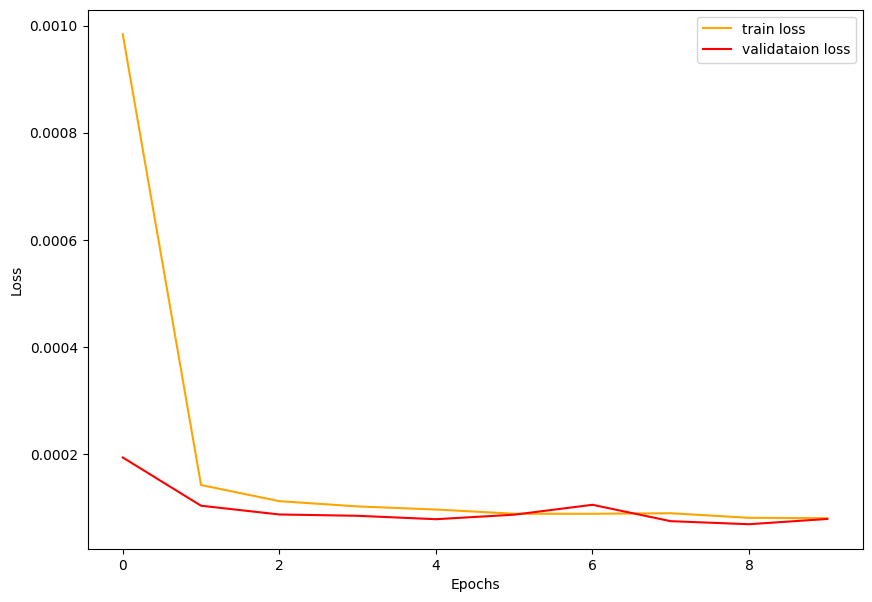

In [ ]:
# loss plots

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/MajorP/Models-trained/srcnnplot.jpg')
plt.show()
# # save the model to disk
# print('Saving model...')
# torch.save(model.state_dict(), '/content/drive/MyDrive/idb/srup/model.pth')

In [ ]:
def predict(model, image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        sharp_tensor = model(image_tensor)
    return sharp_tensor

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Load image

blur_image = Image.open("/content/drive/MyDrive/MajorP/testblur.jpeg")
# blur_image.show()
# Convert grayscale to RGB
if blur_image.mode == 'L':
    blur_image = blur_image.convert('RGB')

# Apply transformations to the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
tensor_img = transform(blur_image)

# create a batch of size 1
blur_tensor = tensor_img.unsqueeze(0)

# predict the sharp image
sharp_tensor = predict(model, blur_tensor)

# save the output image


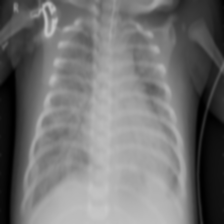

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/MajorP/testblur.jpeg')
blurimg = img.resize((224, 224))
blurimg.show()


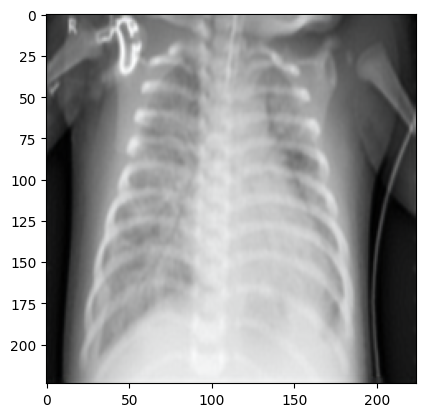

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as utils
shimg = sharp_tensor.view(sharp_tensor.size(0), 3, 224, 224)
img_grid = utils.make_grid(shimg, normalize=True)
plt.imshow(img_grid.permute(1, 2, 0))
plt.show()


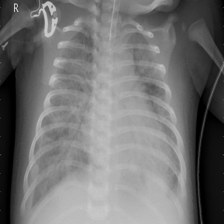

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/MajorP/Testsharp.jpeg')
oriimg = img.resize((224, 224))
oriimg.show()


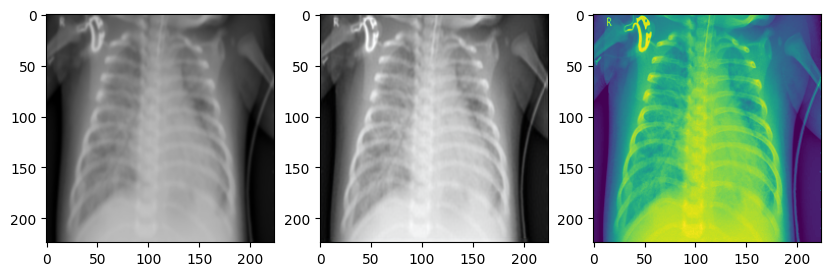

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(blurimg)
axs[1].imshow(img_grid.permute(1, 2, 0))
axs[2].imshow(oriimg)
plt.show()


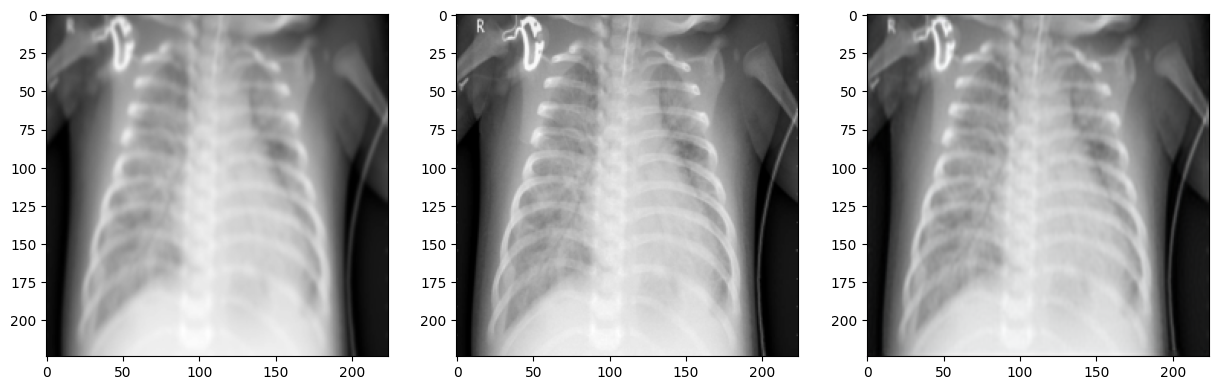

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt

# load images and resize
img1 = Image.open('/content/drive/MyDrive/MajorP/testblur.jpeg')
img2 = Image.open('/content/drive/MyDrive/MajorP/Testsharp.jpeg')
resize = transforms.Resize((224, 224))
img1 = resize(img1)
img2 = resize(img2)


# convert images to tensors
to_tensor = transforms.ToTensor()
tensor1 = to_tensor(img1)
tensor2 = to_tensor(img2)
tensor3 = sharp_tensor

# create image grids
grid1 = utils.make_grid(tensor1, normalize=True)
grid2 = utils.make_grid(tensor2, normalize=True)
grid3 = utils.make_grid(tensor3, normalize=True)

# display the image grids
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(grid1.permute(1, 2, 0))
axs[1].imshow(grid2.permute(1, 2, 0))
axs[2].imshow(grid3.permute(1, 2, 0))
plt.show()


# New Train

In [8]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import argparse
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
%matplotlib inline
import random
import os

gauss_blur = os.listdir('/content/drive/MyDrive/MajorP/datax/blur')
gauss_blur.sort()
sharp = os.listdir('/content/drive/MyDrive/MajorP/datax/sharp/PNEUMONIA')
sharp.sort()

x_blur = []
for i in range(len(gauss_blur)):
    x_blur.append(gauss_blur[i])

y_sharp = []
for i in range(len(sharp)):
    y_sharp.append(sharp[i])


(x_train, x_val, y_train, y_val) = train_test_split(x_blur, y_sharp, test_size=0.25)
print(f"Train data instances: {len(x_train)}")
print(f"Validation data instances: {len(x_val)}")

parser = argparse.ArgumentParser()
parser.add_argument('-e', '--epochs', type=int, default=10, 
            help='number of epochs to train the model for')
parser.add_argument("-f", required=False)

args = vars(parser.parse_args())

#Saving images in particular format...
def save_decoded_image(img, name):
    if img is not None:
        img = img.view(img.size(0), 3, 224, 224)
        save_image(img, name)

# define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class DeblurDataset(Dataset):
    def __init__(self, blur_paths, sharp_paths=None, transforms=None):
        self.X = blur_paths
        self.y = sharp_paths
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        blur_image = cv2.imread(f"/content/drive/MyDrive/MajorP/datax/blur/{self.X[i]}")
        
        if self.transforms:
            blur_image = self.transforms(blur_image)
            
        if self.y is not None:
            sharp_image = cv2.imread(f"/content/drive/MyDrive/MajorP/datax/sharp/PNEUMONIA/{self.y[i]}")
            sharp_image = self.transforms(sharp_image)
            return (blur_image, sharp_image)
        else:
            return blur_image


class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x


batch_size=2
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

train_data = DeblurDataset(x_train, y_train, transform)
val_data = DeblurDataset(x_val, y_val, transform)
 
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

model = DeblurCNN().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/MajorP/Models-saved/srcnn_model9.pth'))




Mounted at /content/drive
Train data instances: 2906
Validation data instances: 969
cpu


<All keys matched successfully>

In [9]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=5,
        factor=0.5,
        verbose=True
    )

def fit(model, dataloader, epoch):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        blur_image = data[0]
        sharp_image = data[1]
        blur_image = blur_image.to(device)
        sharp_image = sharp_image.to(device)
        optimizer.zero_grad()
        outputs = model(blur_image)
        loss = criterion(outputs, sharp_image)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss/len(dataloader.dataset)
    print(f"Train Loss: {train_loss:.5f}")
    
    return train_loss


from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    psnr_total = 0.0
    ssim_total = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            blur_image = data[0]
            sharp_image = data[1]
            blur_image = blur_image.to(device)
            sharp_image = sharp_image.to(device)
            outputs = model(blur_image)
            loss = criterion(outputs, sharp_image)
            running_loss += loss.item()
            
            if epoch == 0 and i == int((len(val_data)/dataloader.batch_size)-1):
              save_decoded_image(sharp_image.cpu().data, name=f"/content/drive/MyDrive/MajorP/Models-trained/SRCNN/sharp{epoch}.jpg")
              save_decoded_image(blur_image.cpu().data, name=f"/content/drive/MyDrive/MajorP/Models-trained/SRCNN/blur{epoch}.jpg")
            if i == int((len(val_data)/dataloader.batch_size)-1):
                 save_decoded_image(outputs.cpu().data, name=f"/content/drive/MyDrive/MajorP/Models-trained/SRCNN/val_deblurred{epoch}.jpg")

            # Calculate PSNR and SSIM
            outputs = outputs.cpu().detach().numpy()
            sharp_image = sharp_image.cpu().detach().numpy()
            outputs = np.transpose(outputs, (0, 2, 3, 1))
            sharp_image = np.transpose(sharp_image, (0, 2, 3, 1))
            for j in range(outputs.shape[0]):
                psnr = peak_signal_noise_ratio(sharp_image[j], outputs[j])
                ssim = structural_similarity(sharp_image[j], outputs[j], multichannel=True)
                psnr_total += psnr
                ssim_total += ssim

    val_loss = running_loss/len(dataloader.dataset)
    psnr_avg = psnr_total/len(dataloader.dataset)
    ssim_avg = ssim_total/len(dataloader.dataset)
    print(f"Val Loss: {val_loss:.5f} | PSNR: {psnr_avg:.5f} | SSIM: {ssim_avg:.5f}")
    torch.save(model.state_dict(), f'/content/drive/MyDrive/MajorP/Models-saved/srcnn_model{epoch}.pth')
    return val_loss, psnr_avg, ssim_avg




In [10]:
train_loss  = []
val_loss = []
PSNR=[]
SSIM=[]
start = time.time()
for epoch in range(10,20):
    print(f"Epoch {epoch+1} of {args['epochs']}")
    train_epoch_loss = fit(model, trainloader, epoch)
    val_epoch_loss,psnr_epoch,ssim_epoch = validate(model, valloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    PSNR.append(psnr_epoch)
    SSIM.append(ssim_epoch)
    scheduler.step(val_epoch_loss)
end = time.time()
print(f"Took {((end-start)/60):.3f} minutes to train")

Epoch 11 of 10


100%|██████████| 1453/1453 [24:26<00:00,  1.01s/it]


Train Loss: 0.00008


  0%|          | 0/484 [00:00<?, ?it/s]<ipython-input-9-a82af4c555b9>:66: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(sharp_image[j], outputs[j], multichannel=True)
485it [06:06,  1.32it/s]


Val Loss: 0.00007 | PSNR: 39.16649 | SSIM: 0.98805
Epoch 12 of 10


100%|██████████| 1453/1453 [10:17<00:00,  2.35it/s]


Train Loss: 0.00008


485it [02:03,  3.94it/s]


Val Loss: 0.00007 | PSNR: 39.38509 | SSIM: 0.98800
Epoch 13 of 10


100%|██████████| 1453/1453 [10:18<00:00,  2.35it/s]


Train Loss: 0.00008


485it [02:03,  3.94it/s]


Val Loss: 0.00007 | PSNR: 39.45333 | SSIM: 0.98816
Epoch 14 of 10


100%|██████████| 1453/1453 [10:15<00:00,  2.36it/s]


Train Loss: 0.00007


485it [02:03,  3.93it/s]


Val Loss: 0.00006 | PSNR: 39.51405 | SSIM: 0.98842
Epoch 15 of 10


100%|██████████| 1453/1453 [10:19<00:00,  2.34it/s]


Train Loss: 0.00010


485it [02:05,  3.86it/s]


Val Loss: 0.00007 | PSNR: 39.08672 | SSIM: 0.98782
Epoch 16 of 10


100%|██████████| 1453/1453 [10:32<00:00,  2.30it/s]


Train Loss: 0.00007


485it [02:06,  3.83it/s]


Val Loss: 0.00007 | PSNR: 39.04143 | SSIM: 0.98702
Epoch 17 of 10


100%|██████████| 1453/1453 [10:34<00:00,  2.29it/s]


Train Loss: 0.00007


485it [02:07,  3.82it/s]


Val Loss: 0.00007 | PSNR: 39.43043 | SSIM: 0.98816
Epoch 18 of 10


100%|██████████| 1453/1453 [10:22<00:00,  2.33it/s]


Train Loss: 0.00007


485it [02:08,  3.77it/s]


Val Loss: 0.00007 | PSNR: 39.44929 | SSIM: 0.98834
Epoch 19 of 10


100%|██████████| 1453/1453 [10:44<00:00,  2.25it/s]


Train Loss: 0.00007


485it [02:06,  3.82it/s]


Val Loss: 0.00007 | PSNR: 39.47328 | SSIM: 0.98810
Epoch 20 of 10


100%|██████████| 1453/1453 [10:40<00:00,  2.27it/s]


Train Loss: 0.00007


485it [02:15,  3.59it/s]

Val Loss: 0.00007 | PSNR: 39.45893 | SSIM: 0.98800
Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.
Took 143.673 minutes to train


In [11]:
def predict(model, image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        sharp_tensor = model(image_tensor)
    return sharp_tensor



REsults with 20 epochs

In [12]:
from PIL import Image
import torchvision.transforms as transforms

# Load image

blur_image = Image.open("/content/drive/MyDrive/MajorP/testblur.jpeg")
# blur_image.show()
# Convert grayscale to RGB
if blur_image.mode == 'L':
    blur_image = blur_image.convert('RGB')

# Apply transformations to the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
tensor_img = transform(blur_image)

# create a batch of size 1
blur_tensor = tensor_img.unsqueeze(0)

# predict the sharp image
sharp_tensor = predict(model, blur_tensor)

# save the output image


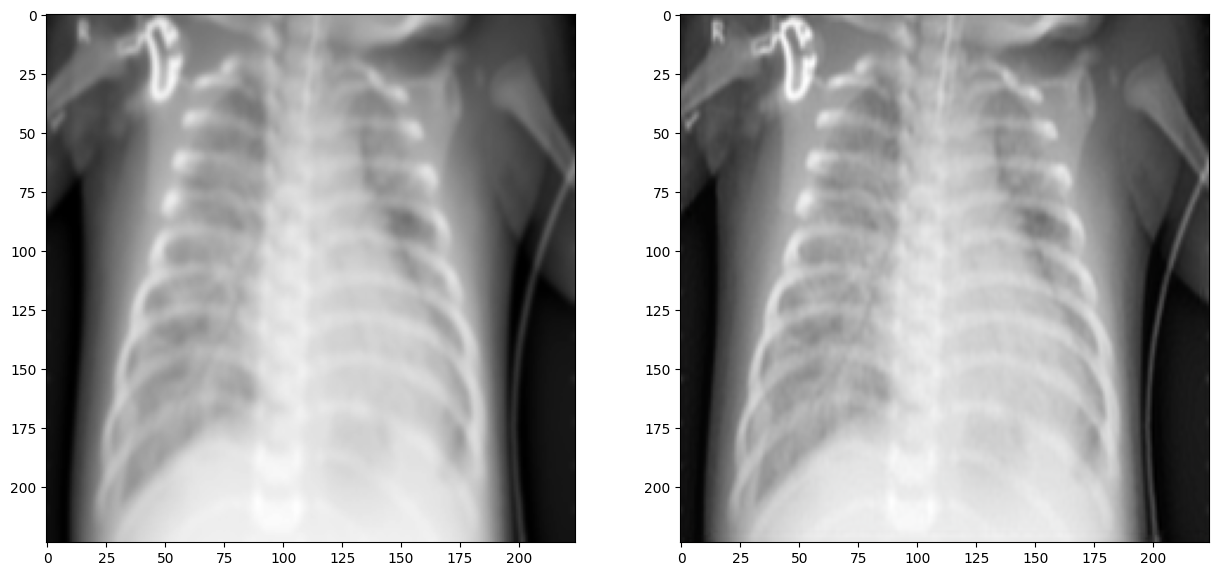

In [14]:
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt

# load images and resize
img1 = Image.open('/content/drive/MyDrive/MajorP/testblur.jpeg')
img2 = Image.open('/content/drive/MyDrive/MajorP/Testsharp.jpeg')
resize = transforms.Resize((224, 224))
img1 = resize(img1)
img2 = resize(img2)


# convert images to tensors
to_tensor = transforms.ToTensor()
tensor1 = to_tensor(img1)
# tensor2 = to_tensor(img2)
tensor3 = sharp_tensor

# create image grids
grid1 = utils.make_grid(tensor1, normalize=True)
# grid2 = utils.make_grid(tensor2, normalize=True)
grid3 = utils.make_grid(tensor3, normalize=True)

# display the image grids
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(grid1.permute(1, 2, 0))
# axs[1].imshow(grid2.permute(1, 2, 0))
axs[1].imshow(grid3.permute(1, 2, 0))
plt.show()


Results with 25 epochs

In [15]:
train_loss  = []
val_loss = []
PSNR=[]
SSIM=[]
start = time.time()
for epoch in range(20,25):
    print(f"Epoch {epoch+1} of {args['epochs']}")
    train_epoch_loss = fit(model, trainloader, epoch)
    val_epoch_loss,psnr_epoch,ssim_epoch = validate(model, valloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    PSNR.append(psnr_epoch)
    SSIM.append(ssim_epoch)
    scheduler.step(val_epoch_loss)
end = time.time()
print(f"Took {((end-start)/60):.3f} minutes to train")

Epoch 21 of 10


100%|██████████| 1453/1453 [10:56<00:00,  2.21it/s]


Train Loss: 0.00007


  0%|          | 0/484 [00:00<?, ?it/s]<ipython-input-9-a82af4c555b9>:66: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(sharp_image[j], outputs[j], multichannel=True)
485it [02:06,  3.82it/s]


Val Loss: 0.00007 | PSNR: 39.52288 | SSIM: 0.98824
Epoch 22 of 10


100%|██████████| 1453/1453 [10:29<00:00,  2.31it/s]


Train Loss: 0.00007


485it [02:09,  3.74it/s]


Val Loss: 0.00006 | PSNR: 39.69238 | SSIM: 0.98857
Epoch 23 of 10


100%|██████████| 1453/1453 [10:47<00:00,  2.24it/s]


Train Loss: 0.00006


485it [02:10,  3.72it/s]


Val Loss: 0.00006 | PSNR: 39.77299 | SSIM: 0.98862
Epoch 24 of 10


100%|██████████| 1453/1453 [10:52<00:00,  2.23it/s]


Train Loss: 0.00006


485it [02:11,  3.70it/s]


Val Loss: 0.00006 | PSNR: 39.60837 | SSIM: 0.98836
Epoch 25 of 10


100%|██████████| 1453/1453 [10:31<00:00,  2.30it/s]


Train Loss: 0.00006


485it [02:15,  3.58it/s]

Val Loss: 0.00006 | PSNR: 39.80834 | SSIM: 0.98866
Took 64.532 minutes to train


In [16]:
from PIL import Image
import torchvision.transforms as transforms

# Load image

blur_image = Image.open("/content/drive/MyDrive/MajorP/testblur.jpeg")
# blur_image.show()
# Convert grayscale to RGB
if blur_image.mode == 'L':
    blur_image = blur_image.convert('RGB')

# Apply transformations to the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
tensor_img = transform(blur_image)

# create a batch of size 1
blur_tensor = tensor_img.unsqueeze(0)

# predict the sharp image
sharp_tensor = predict(model, blur_tensor)

# save the output image


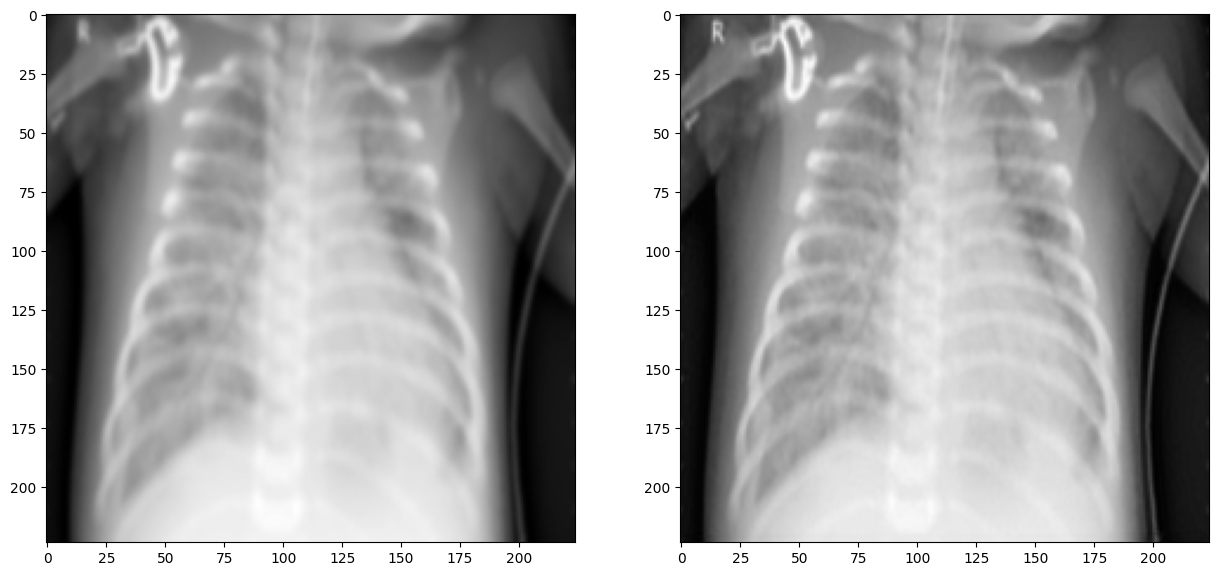

In [17]:
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt

# load images and resize
img1 = Image.open('/content/drive/MyDrive/MajorP/testblur.jpeg')
img2 = Image.open('/content/drive/MyDrive/MajorP/Testsharp.jpeg')
resize = transforms.Resize((224, 224))
img1 = resize(img1)
img2 = resize(img2)


# convert images to tensors
to_tensor = transforms.ToTensor()
tensor1 = to_tensor(img1)
# tensor2 = to_tensor(img2)
tensor3 = sharp_tensor

# create image grids
grid1 = utils.make_grid(tensor1, normalize=True)
# grid2 = utils.make_grid(tensor2, normalize=True)
grid3 = utils.make_grid(tensor3, normalize=True)

# display the image grids
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(grid1.permute(1, 2, 0))
# axs[1].imshow(grid2.permute(1, 2, 0))
axs[1].imshow(grid3.permute(1, 2, 0))
plt.show()


More 5 Epoch
Test on 23

In [18]:
train_loss  = []
val_loss = []
PSNR=[]
SSIM=[]
start = time.time()
for epoch in range(25,30):
    print(f"Epoch {epoch+1} of {args['epochs']}")
    train_epoch_loss = fit(model, trainloader, epoch)
    val_epoch_loss,psnr_epoch,ssim_epoch = validate(model, valloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    PSNR.append(psnr_epoch)
    SSIM.append(ssim_epoch)
    scheduler.step(val_epoch_loss)
end = time.time()
print(f"Took {((end-start)/60):.3f} minutes to train")

Epoch 26 of 10


100%|██████████| 1453/1453 [10:29<00:00,  2.31it/s]


Train Loss: 0.00006


  0%|          | 0/484 [00:00<?, ?it/s]<ipython-input-9-a82af4c555b9>:66: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(sharp_image[j], outputs[j], multichannel=True)
485it [02:04,  3.91it/s]


Val Loss: 0.00006 | PSNR: 39.95865 | SSIM: 0.98886
Epoch 27 of 10


100%|██████████| 1453/1453 [10:17<00:00,  2.35it/s]


Train Loss: 0.00006


485it [02:03,  3.92it/s]


Val Loss: 0.00006 | PSNR: 39.98436 | SSIM: 0.98888
Epoch 28 of 10


100%|██████████| 1453/1453 [10:21<00:00,  2.34it/s]


Train Loss: 0.00006


485it [02:06,  3.83it/s]


Val Loss: 0.00006 | PSNR: 40.11709 | SSIM: 0.98898
Epoch 29 of 10


100%|██████████| 1453/1453 [11:03<00:00,  2.19it/s]


Train Loss: 0.00006


485it [02:02,  3.95it/s]


Val Loss: 0.00006 | PSNR: 39.70240 | SSIM: 0.98850
Epoch 30 of 10


100%|██████████| 1453/1453 [10:20<00:00,  2.34it/s]


Train Loss: 0.00006


485it [02:05,  3.87it/s]

Val Loss: 0.00006 | PSNR: 40.12646 | SSIM: 0.98896
Took 62.928 minutes to train


In [19]:
from PIL import Image
import torchvision.transforms as transforms

# Load image

blur_image = Image.open("/content/drive/MyDrive/MajorP/testblur.jpeg")
# blur_image.show()
# Convert grayscale to RGB
if blur_image.mode == 'L':
    blur_image = blur_image.convert('RGB')

# Apply transformations to the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
tensor_img = transform(blur_image)

# create a batch of size 1
blur_tensor = tensor_img.unsqueeze(0)

# predict the sharp image
sharp_tensor = predict(model, blur_tensor)

# save the output image


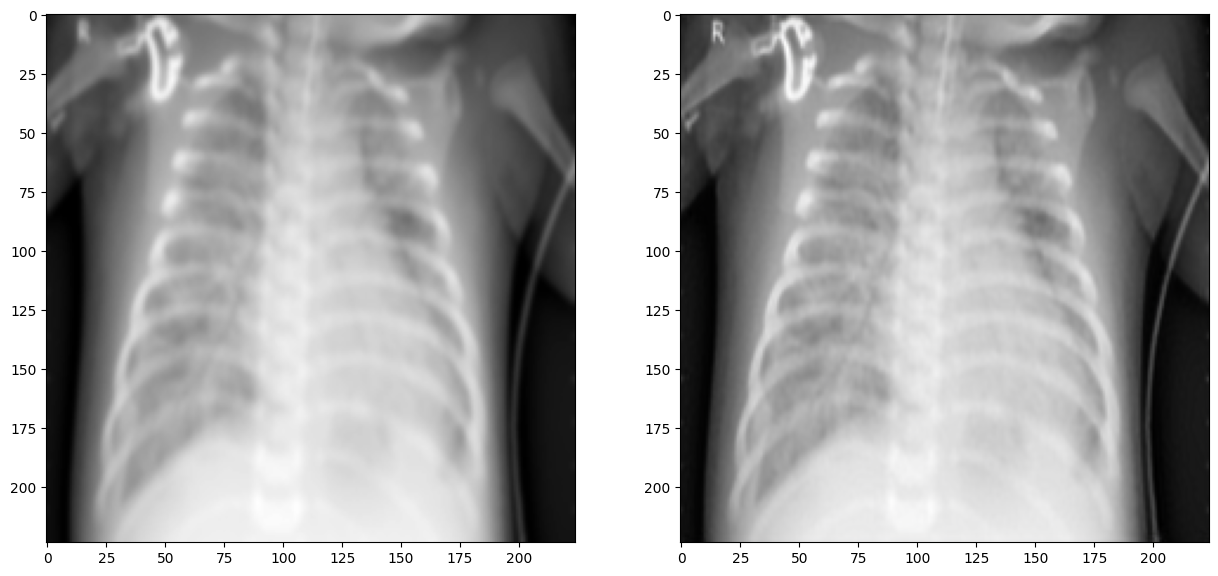

In [20]:
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt

# load images and resize
img1 = Image.open('/content/drive/MyDrive/MajorP/testblur.jpeg')
img2 = Image.open('/content/drive/MyDrive/MajorP/Testsharp.jpeg')
resize = transforms.Resize((224, 224))
img1 = resize(img1)
img2 = resize(img2)


# convert images to tensors
to_tensor = transforms.ToTensor()
tensor1 = to_tensor(img1)
# tensor2 = to_tensor(img2)
tensor3 = sharp_tensor

# create image grids
grid1 = utils.make_grid(tensor1, normalize=True)
# grid2 = utils.make_grid(tensor2, normalize=True)
grid3 = utils.make_grid(tensor3, normalize=True)

# display the image grids
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(grid1.permute(1, 2, 0))
# axs[1].imshow(grid2.permute(1, 2, 0))
axs[1].imshow(grid3.permute(1, 2, 0))
plt.show()


Lets consider 29th model and 24th
